# Load and normalize Pokemons
dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset

## Create train and test sets

In [71]:
from pathlib import Path
from shutil import rmtree, copyfile
import random

random.seed(a=2137)

def create_clean(dir):
    dir.mkdir(parents=True, exist_ok=True)
    rmtree(dir)
    dir.mkdir(parents=True, exist_ok=True)

data_path = Path('./data/images/')
train_path = Path('./data/train/')
test_path = Path('./data/test/')
create_clean(train_path)
create_clean(test_path)

ratio = 0.2
img_id = 0
poke_id = 0
names_to_id = {}
id_to_name = []
for p in data_path.iterdir():
    # print(p.name)
    label = p.name  # pokemon's name
    names_to_id[label] = poke_id
    id_to_name.append(label)
    poke_id += 1
    # copy all dirs from images as they're labels
    (train_path / label).mkdir(parents=True, exist_ok=True)
    (test_path / label).mkdir(parents=True, exist_ok=True)
    for pokemon_path in p.iterdir():
        test_or_train = 'test' if random.random() < ratio else 'train'
        # print('\t', pokemon_path, test_or_train)
        if test_or_train == 'train':
            copyfile(pokemon_path, train_path / label / f'{img_id}.jpg')
        else:
            copyfile(pokemon_path, test_path / label / f'{img_id}.jpg')
        img_id += 1

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

In [72]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class PokemonImageDataset(Dataset):
    def __init__(self, poke_dir, name_to_id, transform=None, target_transform=None):
        self.poke_dir = Path(poke_dir)
        self.image_paths = []
        self.labels_tensor = []
        for poke_path in self.poke_dir.iterdir():
            label = poke_path.name
            for image_path in poke_path.iterdir():
                self.image_paths.append(image_path)
                self.labels_tensor.append(name_to_id[label])
        self.labels_tensor = torch.LongTensor(self.labels_tensor)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = self.labels_tensor[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [77]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

poke_size = 32

transform = v2.Compose(
    [v2.Resize((poke_size, poke_size)),
     v2.ToDtype(torch.float32, scale=True),
     v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64


training_data = PokemonImageDataset('./data/train', names_to_id, transform=transform)
test_data = PokemonImageDataset('./data/test', names_to_id, transform=transform)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

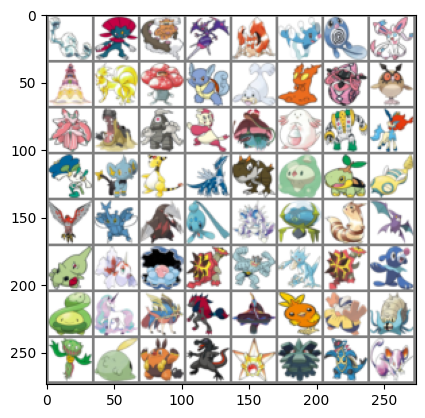

Geodude Weavile Landorus Naganadel Kingler Brionne Poliwag Sylveon Alcremie Ninetales Vileplume Wartortle Seel Slugma Tapu Lele Hoothoot Lurantis Hippowdon Dusclops Mienfoo Venusaur Chansey Regigigas Keldeo Floette Shinx Ampharos Dialga Tyrunt Duosion Turtwig Dunsparce Talonflame Heracross Excadrill Phione Nidoking Dewpider Furret Crobat Larvitar Goldeen Clamperl Turtonator Machamp Golduck Turtonator Popplio Budew Rapidash Zacian Zoroark Inteleon Torchic Hariyama Omastar Carnivine Gulpin Pignite Salandit Staryu Pineco Armaldo Rattata


In [80]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{id_to_name[labels[j]]}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

In [81]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(3*poke_size**2, max(3*poke_size**2 / 4, 898))
        self.fc2 = nn.Linear(max(3*poke_size**2 / 4, 898), max(3*poke_size**2 / 8, 898))
        self.fc3 = nn.Linear(max(3*poke_size**2 / 8, 898), 898)  # 898 -- number of pokemons

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3. Define a Loss function and optimizer

In [82]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network

In [83]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [84]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. Test the network on the test data

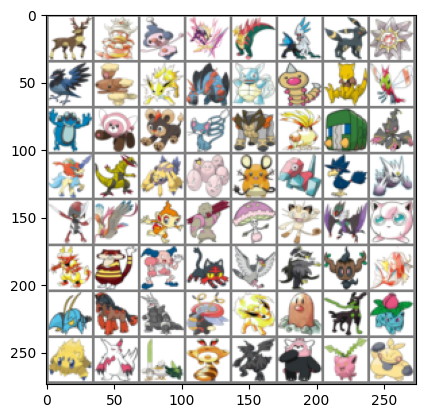

GroundTruth:  Sawsbuck Slowking Mime Jr Toxtricity Dracozolt Silvally Umbreon Starmie Corvisquire Buneary Jolteon Swampert Wartortle Weedle Abra Yanma Seismitoad Stufful Litleo Glameow Terrakion Pidgeot Charjabug Banette Keldeo Haxorus Galvantula Exeggcute Dedenne Porygon Murkrow Gengar Pawniard Pidgeot Chimchar Gurdurr Shiinotic Meowth Noivern Jigglypuff Magmar Watchog Mr. Mime Litten Tranquill Urshifu Phantump Magikarp Clauncher Mudsdale Aggron Volbeat Flareon Diglett Zygarde Ivysaur Joltik Zangoose Sirfetch'd Sentret Zekrom Bewear Hoppip Makuhita


In [85]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{id_to_name[labels[j]]}' for j in range(batch_size)))

In [86]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [87]:
outputs = net(images)

In [89]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{id_to_name[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Lycanroc Lycanroc Chinchou Lycanroc Cradily Cyndaquil Lycanroc Lycanroc Claydol Grimer Lycanroc Corviknight Lycanroc Hippowdon Corviknight Lycanroc Machop Croagunk Scizor Spheal Lycanroc Spheal Corviknight Magnemite Lycanroc Reshiram Lycanroc Spheal Spheal Lycanroc Nidoqueen Spheal Cyndaquil Cradily Lycanroc Magnemite Grimer Spheal Garbodor Magnemite Lycanroc Delphox Spheal Shellder Lycanroc Moltres Lycanroc Lycanroc Spheal Corviknight Cradily Grimer Lycanroc Lycanroc Cradily Cradily Ninjask Croagunk Spheal Lycanroc Corviknight Corviknight Lycanroc Spheal


In [90]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %


In [93]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in id_to_name}
total_pred = {classname: 0 for classname in id_to_name}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[id_to_name[label]] += 1
            total_pred[id_to_name[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
    else:
        accuracy = 0
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Hakamo-o is 0.0 %
Accuracy for class: Skuntank is 0.0 %
Accuracy for class: Snorunt is 0.0 %
Accuracy for class: Wartortle is 0.0 %
Accuracy for class: Hatterene is 0.0 %
Accuracy for class: Fennekin is 0.0 %
Accuracy for class: Torkoal is 0.0 %
Accuracy for class: Torterra is 0.0 %
Accuracy for class: Popplio is 0.0 %
Accuracy for class: Whiscash is 0.0 %
Accuracy for class: Luvdisc is 0.0 %
Accuracy for class: Serperior is 0.0 %
Accuracy for class: Jynx  is 0.0 %
Accuracy for class: Pancham is 0.0 %
Accuracy for class: Patrat is 0.0 %
Accuracy for class: Aurorus is 0.0 %
Accuracy for class: Dedenne is 0.0 %
Accuracy for class: Mightyena is 0.0 %
Accuracy for class: Donphan is 0.0 %
Accuracy for class: Krookodile is 0.0 %
Accuracy for class: Morelull is 0.0 %
Accuracy for class: Machamp is 0.0 %
Accuracy for class: Treecko is 0.0 %
Accuracy for class: Genesect is 0.0 %
Accuracy for class: Gliscor is 0.0 %
Accuracy for class: Swadloon is 0.0 %
Accuracy for class: Ni

# Training on GPU

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


# Resources
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://pytorch.org/vision/stable/transforms.html
* https://docs.python.org/3/library/pathlib.html#

In [94]:
# CONCLUSION: There is too ******* many pokemons